# Assignment 4: Markov Chain Monte Carlo

## Part 0: Introduction/Background

The following is some introductory terminology and 'get-started' exercises. **Part 0 is not a required part of the assignment, but may be useful to work through if you want to learn the basics.** It may also be familiar to you if you took ph20.

### 0.0 Theorems and terminology - Bayes' theorem

Imagine we have some data for a system that can be well described by a model, $M$. $M$ is characterized by some parameters $\mathbf{X} = \{ x_1, x_2, \ldots, x_M \}$. Suppose we have $N$ data, $\mathbf{D} = \{ d_1, d_2, \ldots, d_N \}$. Bayes' theorem states that

\begin{equation}
p(\mathbf{X} | \mathbf{D}, I) = \frac{p(\mathbf{D}|\mathbf{X}, I) p(\mathbf{X}|I)}{p(\mathbf{D}|I)}.
\end{equation}

In words, we may say: "The probability that the model parameters $\mathbf{X}$ are correct, given the data, is proportional to the probability of the data occuring, given the model parameters, multiplied by the probability of the model parameters, given our prior information about the system". Here, we ignore the denominator (which serves to correctly normalize our result as a probability).

$p(\mathbf{X}|I)$ is referred to as the **prior**, $p(\mathbf{X}|\mathbf{D}, I)$ is the **posterior**, and $p(\mathbf{D}|\mathbf{X}, I)$ is the **likelihood**.

### 0.1 Bayes' theorem example - Coin flipping

Suppose you flip a coin. $H$ is the probability of getting heads after flipping the coin once (for a normal, unbiased coin, this would be $0.5$). Suppose that we flip the coin $n$ times, and that $h$ heads occur. $h$ heads occur with probability $H^h$, and $n-h$ tails occur with probability $(1-H)^{n-h}$. We also need to account for all of the different orderings in which we could've gotten heads and tails. Overall, then, our **likelihood** is given by

\begin{equation}
p(\mathbf{D} | H, I) = \frac{n!}{h!(n-h)!}H^h (1-H)^{n-h}.
\end{equation}

Now, we must choose a **prior**, which is the probability for $H$, given the information. As of now we do not have any information about the system - we haven't been given a chance to inspect our coin or our environment. So, we choose something very basic, the uniform distribution: $p(\mathbf{H}|I) = 1$. If we had inspected the coin and were reasonably certain that it was a fair, unbaised coin, we may have chosen something like a normal distribution peaked around $0.5$, to demonstrate our **belief** that $H=0.5$.

The idea now is to compute the posterior, which will take into account information both about the data, and also about our prior assumptions. After computing the posterior, we should have a good **parameter estimate** for $H$. 

Your task is to demonstrate this idea by completing the code below. The code generates some data - flipping a biased coin 100 times. **Your practice tasks are denoted by comments 1-5 in the code block below**.

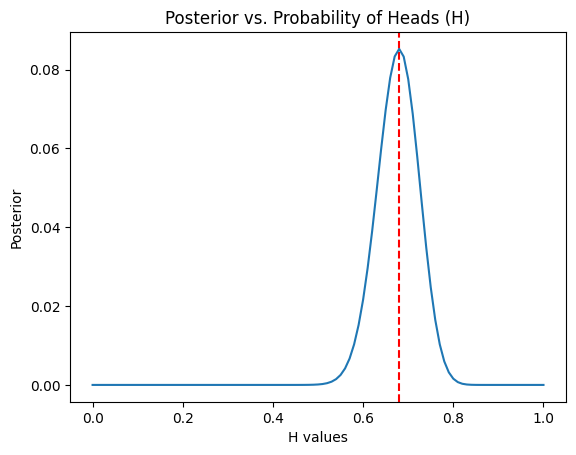

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special

## Generate some coin flipping data

H_true = 0.6 ## this is the true value of H - assume that we are flipping a 'slightly biased' coin
n = 100      ## flip the coin 100 times
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data<=H_true)])))  ##counts number of heads

## apply bayes' theorem to estimate H
prior = 1
dH = 0.01
eps = 1e-6 

## 1: A list of potential values for H
H_vals = np.linspace(0, 1, int(1/dH)+1)

# 2: loop through the proposed values of H and compute the posterior
posterior = []

for H in H_vals:
    # 3: code in the likelihood described above (hint: scipy!)
    likelihood = special.comb(n, h) * H**h * (1-H)**(n-h)

    # 4: compute the posterior and add to list. We ignore the denominator, because it is just an overall scaling factor
    posterior = np.append(posterior, likelihood * prior)

# 5: Plot the resulting posterior distribution and include a vertical line to 
#    show the true value of H
plt.xlabel("H values")
plt.ylabel("Posterior")
plt.title("Posterior vs. Probability of Heads (H)")

max_H = H_vals[np.argmax(posterior)]
plt.axvline(x=max_H, color='red', linestyle='--')

bayes_plot = plt.plot(H_vals, posterior)


### 0.2 Background - Monte Carlo methods

Bayesian parameter estimation does not scale well when we have lots of parameters in our system. Imagine we had a problem with two parameters to tune, $A$ and $B$. We could form a grid of potential values for $A$ and $B$, and compute the posterior over the grid. However, as the number of parameters increases, this method (very quickly) becomes unrealistic, as there are far too many points to sample over.

**An example - estimating pi**

Monte Carlo methods are methods which use random sampling to obtain numerical results. Let's demonstrate the idea by using Monte Carlo to estimate the value of $\pi$. Consider a quarter circle which is incribed in the unit square. The area of the square is $1$, and the area of the quarter circle is $\frac{\pi r^2}{4} = \frac{\pi}{4}$. This means that the ratio of the square's area to the quarter circle's area is $\pi/4$. Imagine throwing a bunch of darts at the square (uniformly scattering some points over the square). If the distance from the origin to a specific point is less than $1$, the point must be inside the quarter circle. We would expect that the ratio of the number of points inside the circle to the total number of points would be approximately $\pi/4$. Let's check try this out in the code below.


In [3]:
import numpy as np
n = 1000
in_circ = 0
for _ in range(n):
    pos = np.random.rand(2)
    dist = np.sqrt(pos[0]**2 + pos[1]**2)
    if dist < 1:
        in_circ += 1
pi = 4*in_circ/n
pi

3.156

### 0.3 Markov Chain Monte Carlo - the idea + some definitions

See numerical recipes section 15.8 if you are interested in a more detailed introduction.

MCMC is a random sampling method: we wish to visit a point $x$ in our sampling space according to some distribution $\pi(x)$, which for us will be the unknown posterior distribution. MCMC automatically samples the points where $\pi$ is large preferentially. There are two insights that make MCMC work well.

1) $\pi$ is sampled via a **Markov Chain**. This means that instead of each point being sampled independently, each point depends directly on the previously sampled point. This 'memory' only goes back one step in time. We represent this by a transition probability $p(x_n | x_{n-1})$.
2) The detailed balance condition: $$ \pi(x_1) p(x_2 | x_1) = \pi(x_2) p (x_1| x_2).$$

These two insights ensure that MCMC has the **ergodic property** eventually, we will visit all points in the sample space with probability proportional to $\pi$.

**The Metropolis-Hastings algorithm**

This is an example of an MCMC algorithm. The steps are, roughly, as follows:

1) Pick a proposed transition distribution q(x_2|x_1).
2) From your starting point, $x_1$, generate a candidate step $x_{2c}$.
3) Compute an acceptance probability $$\alpha(x_1, x_{2c}) = \texttt{min}\left(1, \frac{\pi(x_{2c}) q(x_1|x_2))}{\pi(x_1)q(x_{2c}|x_1)}\right).$$
4) Either accept or reject the next step.

### 0.4 MCMC in python - the coin flipping example again

There are a few packages available for doing MCMC in python. In this practice exercise, you will use the emcee package to redo the coin-tossing example at the beginning of this document. In the blocks below, you are provided with a skeleton code and commented instructions. When you are finished writing the code, try changing a few of the parameters such as the number of walkers, or the number of steps that the MCMC sampler runs for. Comment on how changing these parameters effects the outcome of your results.

In [5]:
import numpy as np
import emcee
from numpy.random import randn, rand
import matplotlib.pyplot as plt
#import matplotlib as mpl
import matplotlib.gridspec as gridspec
import corner

# to check code execution times
from timeit import default_timer as timer

In [7]:
## define the probability distributions. NOTE: probabilities can be ZERO and the log of zero is infinite. make sure you include something in your code to catch
## the infinities. Returning -infinity is allowed by emcee.

# returns the log of the chosen prior
def log_prior(H):
    # we assume a uniform prior, within the range of probabilities [0, 1]. If H is outside of this range, that return -inf, as suggested
    if 0 <= H <= 1:
        return np.log(1)
    else:
        return -np.inf

# returns the log the likelihood
def log_likelihood(H, h, n):
    if 0 <= H <= 1:
        likelihood = special.comb(n, h) * H**h * (1-H)**(n-h)

        # if the probability is too small, return -inf
        if likelihood < 1e-50:
            return -np.inf
        else:
            return np.log(likelihood)
    return -np.inf

# returns the log posterior, which is (up to an additive constant) is just the sum of the log prior and log likelihood
def log_posterior(H, h, n):
    if 0 <= H <= 1:
        return log_prior(H) + log_likelihood(H, h, n)
    else:
        return -np.inf

In [9]:
## input reasonable values for the parameters

ndim = 1
n_walkers = 100

In [11]:
## generating the "observed data"

n = 500
H_true = 0.5
data = np.random.rand(n)
h = int(np.sum(np.ceil(data[np.where(data>=H_true)])))

In [13]:
## running the MCMC simulation. 

# define p0, the random starting points for each of the walkers
p0 = np.random.rand(n_walkers, ndim)
# instantiate the sampler
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_posterior, args=[h, n])
# run a few "burn in steps"
state = sampler.run_mcmc(p0, 100)
sampler.reset()
# run the MCMC sampler.
sampler.run_mcmc(state, 1000);

C:\Users\jason\anaconda3\envs\ph21env\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


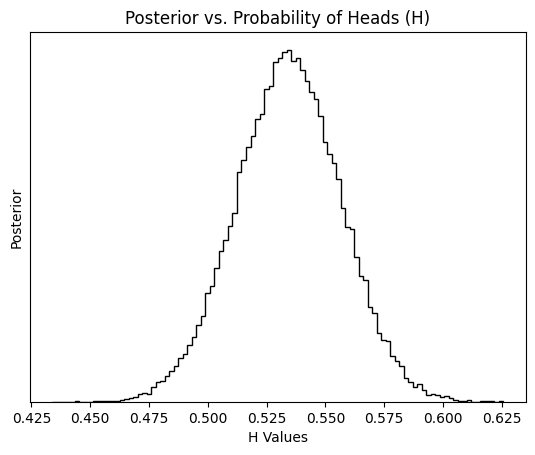

In [15]:
# plotting the resulting posterior
samples = sampler.get_chain(flat=True)
plt.hist(samples, 100, color="k", histtype="step")
plt.xlabel("H Values")
plt.ylabel("Posterior")
plt.title("Posterior vs. Probability of Heads (H)")
plt.gca().set_yticks([]);

## Tuning the parameters
- Surprisingly, the most sensitive parameter in my analysis was the value of epsilon chosen, under which a log-likeihood of -inf is returned. I ended up setting this value to 1e-50, because for values that are low but not low enough (e.g. 1e^-10), there are some chains that get "stuck", with an acceptance probability of 0%.
- Increasing the number of steps that the sampler runs for has the effect of making the distribution smoother, as does increasing the number of walkers. The posteriors associated with the values of H do not seem to be significantly impacted, however.

## Part 1: Galaxy Rotation Curves

**This part of the assignment is compulsory.**

Galaxy rotation curves plot the orbital speeds of objects in the galaxy versus their radial distance from the center of the galaxy. The experimentally observed curves differ greatly from those that are generated by applying Newtonian mechanics to the known matter in the galaxy - this discrepency can be resolved by involving dark matter.

In this assignment, you will set up a model for a galaxy rotation curve involving dark matter and use MCMC to fit the model parameters. You will use the emcee package to do this - if you are not familiar with this, the quickstart page in the docs is very informative. Part 0.4 can be used as a warm-up example if you need some more help.

### 1.0 Setting up a model

The total velocity is calculated as a combination of the visible matter velocity and the dark matter velocity.

Write a function to compute the velocity function for dark matter. We will model this using the Navarro-Frenk-White (NFW) profile. First, solve for velocity by equating the centripital force to Newtonian gravitational force. Then, eliminate the mass using information from the NFW wikipedia page: https://en.wikipedia.org/wiki/Navarro–Frenk–White_profile

By equating the centripetal acceleration to the acceleration due to Newtonian gravity, we have that $$\frac{v^2}{R}=\frac{GM}{R^2},$$ where $M$ is the integrated mass of dark matter within radius $R$. This implies that $$v(R)=\sqrt{\frac{GM}{R}}.$$ Using https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile, we are given that 
$\rho(r)=\frac{\rho_0}{\frac{r}{R_s}(1+\frac{r}{R_s})^2}$, implying that $$M(R)=4\pi\rho_0R_s^3\left[\ln\left(\frac{R_s+R}{R_s}\right)-\frac{R}{R_s+R}\right],$$ where $\rho_0$ and $R_s$ are specific characteristics of the dark matter halo in question. We can then plug this mass into the earlier expression to determine the velocity function for dark matter as a function of radius.

In [17]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [19]:
# Define the velocity function for visible matter
def visible_matter_velocity(r, v_bulge_max, r_bulge):
    """
    Calculate the rotation curve velocity due to visible matter, modeled with a simple bulge component.
    """
    v_bulge = v_bulge_max * np.tanh(r / r_bulge)
    return v_bulge

# Define the velocity function for dark matter (NFW profile)
def nfw_velocity(r, rho_0, r_s):
    """
    Calculate the rotation curve velocity for the NFW dark matter profile.
    """
    G = 6.6743e-11
    
    # Ensure that units are correct (convert from km/s to kpc/s)
    kpc_to_km = 3.08567758e16
    conversion_factor = 1e-21
    rho_actual = rho_0*conversion_factor
    M = 4 * np.pi * rho_actual * r_s**3 * (np.log((r_s+r)/r_s)-r/(r_s+r))
    v_nfw = np.sqrt(G*M/r)
    return kpc_to_km*v_nfw


# Total velocity combining both contributions
def total_velocity(r, v_bulge_max, r_bulge, rho_0, r_s):
    
    """
    Calculate the total rotation curve velocity, combining contributions from visible and dark matter.
    """
    v_visible = visible_matter_velocity(r, v_bulge_max, r_bulge)
    v_nfw = nfw_velocity(r, rho_0, r_s)
    return np.sqrt(v_visible**2 + v_nfw**2)

# The r values start at 0.1 instead of 0 to avoid division by 0 in calculating dark matter velocities
rs = np.arange(0.1, 30, 0.1)
vs = visible_matter_velocity(rs,150,2)
vdm = nfw_velocity(rs, 1, 10)

### 1.1 Simulating some data

We are going to attempt to fit our theoretical model (defined above) to some noisy simulated data. In this step, write a function that simulates this data by computing the total velocity and adding random noise to the data.

In [21]:
# Function to simulate galaxy rotation curve data with noise. Takes as input an array of radius r (and a few optional parameters)
def simulate_data(r, v_bulge_max=150, r_bulge=2, rho_0=1, r_s=10, noise_level=5):
    """
    Simulate rotation curve data for a galaxy with contributions from both visible matter (bulge/disk) and dark matter (NFW profile).
    """
    return [total_velocity(r_value, v_bulge_max, r_bulge, rho_0, r_s) + np.random.normal(0, noise_level) for r_value in r]

### 1.2 MCMC setup

Next, write three functions that return the (log) prior, likelihood, and posterior. The prior should be used to reasonably constrain the values of the parameters. The likelihood is our model, given by total velocity. Constrain the parameters to obey $100 < v_{bm} < 200$ ($\text{km/s}$), $0<r_b<4$ $\text{(kpc)}$, $0.5<\rho_0<1.5*10^{-22}$ ($\text{kg}/\text{m}^3$), $0<r_s<50$ ($\text{kpc}$).

## Plan of attack
- For the prior, we will assume a uniform prior over the constrained intervals.
- For the likelihood, we will take a Gaussian with some characteristic noise $\sigma$. The probability density function of each individual prediction point $v_{j,obs}$ is then $$f(v_{j,obs})\propto \exp{\left(-\frac{1}{2}\frac{(v_{j,obs}-v_{j,pred})^2}{\sigma^2}\right)}.$$ This means that the probability of a given sequence of observations $\mathbf{v_{obs}}$, assuming that the observations are independence, is given as $$p(\mathbf{v_{obs}})\propto\prod_{j}f(v_{j,obs})$$ and the relevant log-likelihood is given as $$L(\mathbf{v_{obs}})=-\frac{1}{2\sigma^2}\sum_j(v_{j,obs}-v_{j,pred})^2+C,$$ which is clearly related to the sum of squared distances between the predicted and observed distributions (up to some constant $C$).

In [23]:
# Log-prior function
def log_prior(theta):
    """
    Define the prior probabilities for the model parameters.
    """

    # We assume a uniform prior in the available parameter space
    v_bm, r_b, rho_0, r_s = theta
    if 100 < v_bm < 200 and 0 < r_b < 4 and 0.5 < rho_0 < 1.5 and 0 < r_s < 50:
        return np.log(1)
    else:
        return -np.inf

# Log-likelihood function
def log_likelihood(theta, r, v_observed):
    """
    Calculate the log likelihood of the observed data given the model parameters.
    """
    v_bm, r_b, rho_0, r_s = theta

    # check to see if the suggested parameters are in the valid range
    if 100 < v_bm < 200 and 0 < r_b < 4 and 0.5 < rho_0 < 1.5 and 0 < r_s < 50:
        v_predicted = [total_velocity(r_value, v_bm, r_b, rho_0, r_s) for r_value in r]
    
        # We use a Gaussian distribution to compute the log likelihood, which ends up being proportional to mean-squared error (MSE)
        log_likelihood = -0.5/noise**2 * np.sum((np.array(v_predicted)-np.array(v_observed))**2)
        return log_likelihood
    else:
        return -np.inf

# Total log-probability function
def log_probability(theta, r, v_observed):
    return log_prior(theta) + log_likelihood(theta, r, v_observed)

### 1.3 MCMC run and result

Now, run the MCMC simulation and plot the resulting best-fit model along with the data points.

Create a corner plot of the results. How do you interpret this corner plot?

In [25]:
# generate the simulated data
noise = 5
v_observed = simulate_data(rs, noise_level = noise)

ndim = 4
n_walkers = 100

# initialize the parameters randomly within the parameter space that is valid
v_bm_init = np.random.uniform(100, 200, n_walkers)
r_b_init = np.random.uniform(0, 4, n_walkers)
rho_0_init = np.random.uniform(0.5, 1.5, n_walkers)
r_s_init = np.random.uniform(0, 50, n_walkers)

p0 = np.column_stack([v_bm_init, r_b_init, rho_0_init, r_s_init])

# instantiate the sampler
sampler = emcee.EnsembleSampler(n_walkers, ndim, log_probability, args=[rs, v_observed])
# run a few "burn in steps"
state = sampler.run_mcmc(p0, 500)
sampler.reset()
# run the MCMC sampler.
sampler.run_mcmc(state, 500);
samples = sampler.get_chain(flat=True)

### Plotting
First, we plot the observed/simulated data, overlayed with the MCMC best-fit model (where we take the median of the samples to find the model predictions). Then, we plot the corner plots relating the four parameters $v_{bm}$, $r_b$, $\rho_0$, and $r_s$.

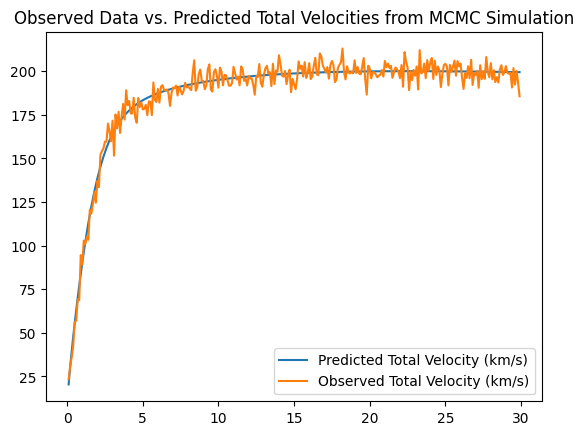

In [27]:
# Take the median of all the chains to get the MCMC model predictions for the parameters
v_bm_fit, r_b_fit, rho_0_fit, r_s_fit = np.median(samples, axis=0)

# Calculate the model predictions for total velocity
v_predicted = [total_velocity(r_value, v_bm_fit, r_b_fit, rho_0_fit, r_s_fit) for r_value in rs]

# Plot observed vs. predicted total velocity graphs
predicted_plot = plt.plot(rs, v_predicted, label=r'Predicted Total Velocity (km/s)')
observed_plot = plt.plot(rs, v_observed, label=r'Observed Total Velocity (km/s)')
plt.title("Observed Data vs. Predicted Total Velocities from MCMC Simulation")
legend = plt.legend()

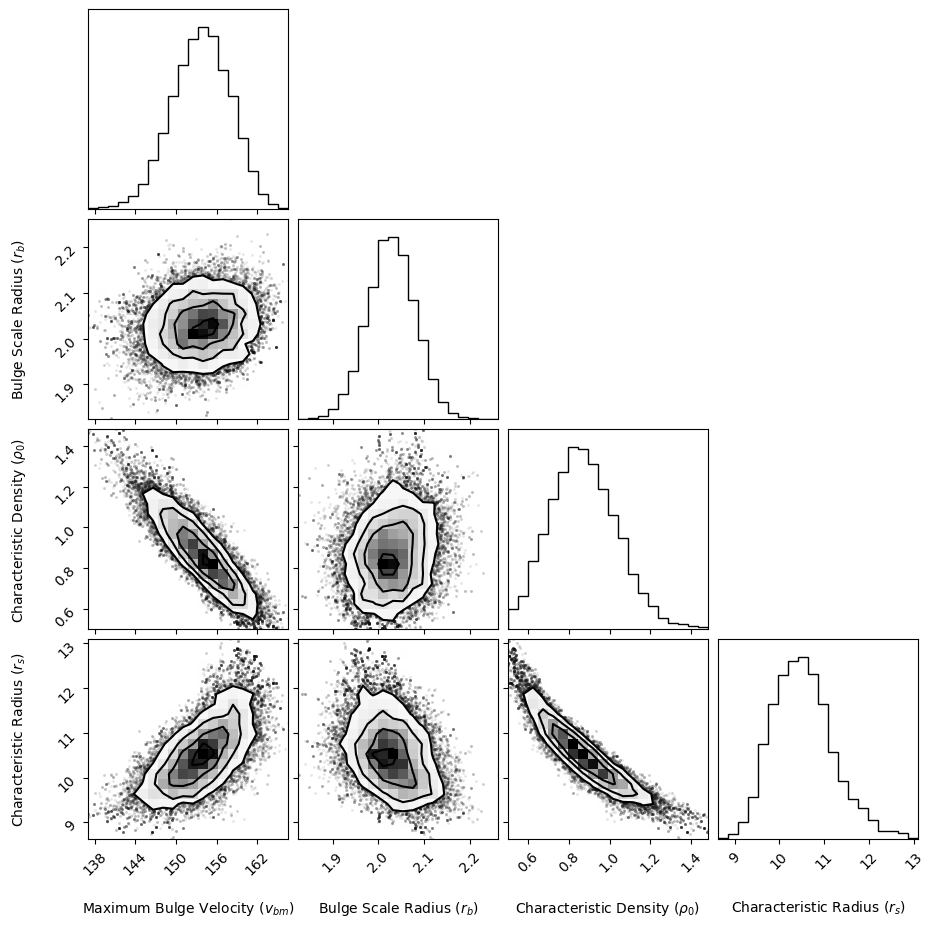

In [29]:
figure = corner.corner(samples[:], labels=[r"Maximum Bulge Velocity ($v_{bm}$)",r"Bulge Scale Radius ($r_b$)",r"Characteristic Density ($\rho_0$)",r"Characteristic Radius ($r_s$)"])
plt.show()

## Intepretation of the Corner Plot

We see that the density of the pairwise corner plots are the highest near the values of the parameters we used to actually run the model. In particular, $v_{bm}$ is close to $150\text{ km/s}$, $r_b$ is close to $2\text{ kpc}$, $\rho_0$ is close to $10^{-22}\text{ kg}/\text{m}^3$, and $r_s$ is close to  $10\text{ kpc}$. This means that the chains in our MCMC model have converged to the appropriate parameters. The one-dimensional corner plots also indicate this clearly.